In [15]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplot

import numpy as np
import os
from skimage import data, io, transform
import math
from skimage.color import rgb2gray
LennaPth = "./Lenna_(test_image).png"
if not os.path.isfile(LennaPth):
    !wget https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png

In [17]:
def match_cdf(source_im, target_im):
    #unique values, their indeces, their counts 
    s_unique_values, src_unique_indices, s_unique_counts = np.unique(source_im.ravel(), return_inverse=True, return_counts=True)

    t_unique_values, t_unique_counts = np.unique(target_im.ravel(), return_counts=True)

    #computing cdf
    src_cdf = np.cumsum(s_unique_counts) / source_im.size
    temp_cdf = np.cumsum(t_unique_counts) / target_im.size

    #mapping src_cdf to temp_cdf with interpolation
    interp_a_values = np.interp(src_cdf, temp_cdf, t_unique_values)
    return interp_a_values[src_unique_indices].reshape(source_im.shape)

In [21]:
def dap_hist_matching(source_im,target_im,D):
    s_h,s_w = source_im.shape
    t_h,t_w = target_im.shape
    if source_im.dtype != np.uint8 or target_im.dtype != np.uint8:
        raise ValueError("Wrong input, source_im is np.uint8 and target_im is np.uint8")
    if s_h < D or s_w< D or t_h < D or t_w < D:
        print("Warning: D is greater than source or target image")
    if s_h%D or s_w%D:
        print("Warnnig: Source_dims/D is not whole number")
    if s_h < 1 or s_w < 1 or t_h < 1 or t_w < 1:
         raise ValueError("Wrong input array")
    
    s_Mask = (D,D)
    Dh_t_mask =D*t_h//s_h
    Dw_t_mask = D*t_w//s_w
    t_Mask =(Dh_t_mask,Dw_t_mask)
    y = math.ceil(s_h/D)
    x = math.ceil(s_w/D)

    #------------------------------------------------------PLOTTING--------------------------------------------

    for i in range(y):
        for j in range(x):
            plt.figure(figsize=(20,2))
            if s_Mask[1]*(i+1) > s_h and s_Mask[0]*(j+1) > s_w:
                source_t = source_im[s_Mask[0]*i:-1,s_Mask[1]*j:-1]
                target_t = target_im[t_Mask[0]*j:-1,t_Mask[1]*j:-1]
                match_t = match_cdf(source_t,target_t)
                plots(source_t,target_t,match_t,1)
                    
            elif s_Mask[1]*(i+1) > s_h:
                source_t = source_im[s_Mask[0]*i:-1,s_Mask[1]*j:s_Mask[1]*(j+1)]
                target_t = target_im[t_Mask[0]*i:-1,t_Mask[1]*j:t_Mask[1]*(j+1)]
                match_t = match_cdf(source_t,target_t)
                plots(source_t,target_t,match_t,2)
                          
            elif s_Mask[0]*(j+1) > s_w:
                source_t = source_im[s_Mask[0]*i:s_Mask[0]*(i+1),s_Mask[1]*(j):-1]
                target_t = target_im[t_Mask[0]*i:t_Mask[0]*(i+1),t_Mask[1]*(j):-1]
                match_t = match_cdf(source_t,target_t)
                plots(source_t,target_t,match_t,3)
            else:
                source_t = source_im[s_Mask[0]*i:s_Mask[0]*(i+1),s_Mask[1]*j:s_Mask[1]*(j+1)]
                target_t = target_im[t_Mask[0]*i:t_Mask[0]*(i+1),t_Mask[1]*j:t_Mask[1]*(j+1)]
                match_t = match_cdf(source_t,target_t)
                plots(source_t,target_t,match_t,4)

#------------------------------------------Algorithm-------------------------------------------------------
    for i in range(y):
        for j in range(x):
            if s_Mask[1]*(i+1) > s_h and s_Mask[0]*(j+1) > s_w: # if mask is is out of picture width and height dimensions 
                source_im[s_Mask[0]*i:-1,s_Mask[1]*j:-1] = match_cdf(
                source_im[s_Mask[0]*i:-1,s_Mask[1]*j:-1],
                target_im[t_Mask[0]*j:-1,t_Mask[1]*j:-1])
                
            elif s_Mask[1]*(i+1) > s_h: #if mask is is out of picture height dimension
                source_im[s_Mask[0]*i:-1,s_Mask[1]*j:s_Mask[1]*(j+1)] = match_cdf(
                source_im[s_Mask[0]*i:-1,s_Mask[1]*j:s_Mask[1]*(j+1)],
                target_im[t_Mask[0]*i:-1,t_Mask[1]*j:t_Mask[1]*(j+1)])
                          
            elif s_Mask[0]*(j+1) > s_w:# if mask is is out of picture width dimension
                 source_im[s_Mask[0]*i:s_Mask[0]*(i+1),s_Mask[1]*(j):-1] = match_cdf(
                 source_im[s_Mask[0]*i:s_Mask[0]*(i+1),s_Mask[1]*(j):-1],
                 target_im[t_Mask[0]*i:t_Mask[0]*(i+1),t_Mask[1]*(j):-1])

            else:
                source_im[s_Mask[0]*i:s_Mask[0]*(i+1),s_Mask[1]*j:s_Mask[1]*(j+1)]= match_cdf( # computing matching tile with source tile and target tile
                source_im[s_Mask[0]*i:s_Mask[0]*(i+1), s_Mask[1]*j:s_Mask[1]*(j+1)],#source tile with source Mask
                target_im[t_Mask[0]*i:t_Mask[0]*(i+1), t_Mask[1]*j:t_Mask[1]*(j+1)])#target tile with target Mask
    return source_im.astype(np.uint8)

In [24]:
def plots(source_t,target_t,match_t,x):
    subplot(1,5,1)
    plt.title("Source tile, source shape {}".format(source_t.shape))
    plt.imshow(source_t,cmap="gray")
    subplot(1,5,2)
    plt.title("Target tile, source shape {}".format(target_t.shape))
    plt.imshow(target_t,cmap="gray")
    subplot(1,5,3)
    plt.title("Source tile histogram")
    plt.hist(source_t.ravel(),bins=20,histtype="bar",color="green")
    subplot(1,5,4)
    plt.title("Target tile histogram")
    plt.hist(target_t.ravel(),bins=20,histtype="bar",color="red")
    subplot(1,5,5)
    plt.title("Match tile histogram")
    plt.hist(match_t.ravel(),bins=20,histtype="bar",color="blue")

Warnnig: Source_dims/D is not whole number


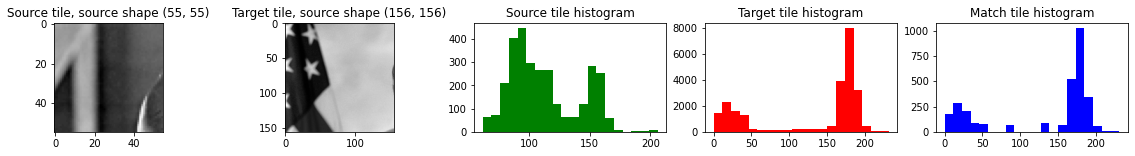

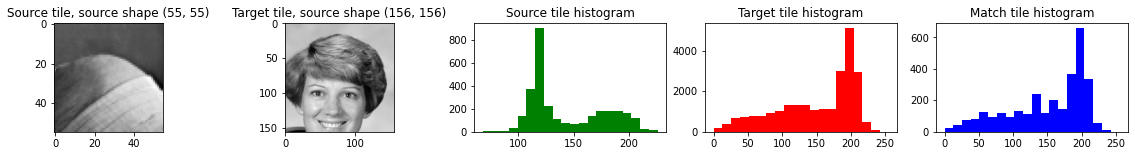

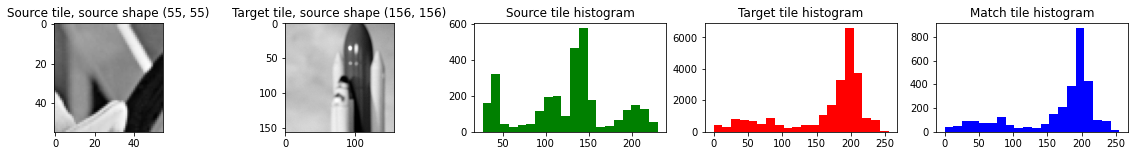

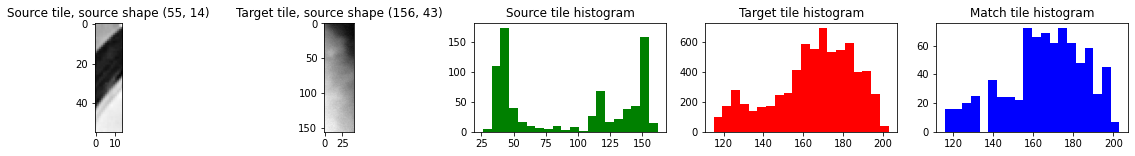

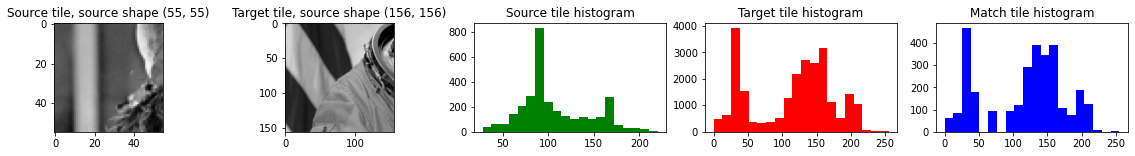

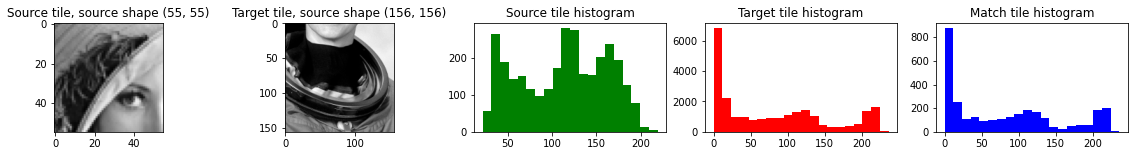

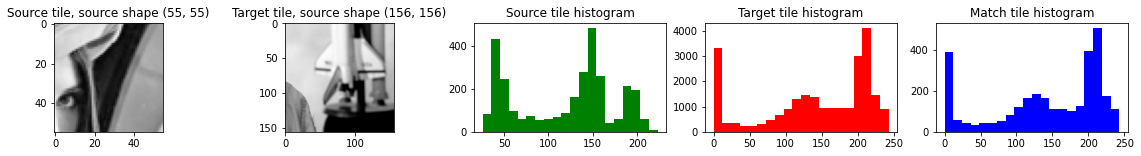

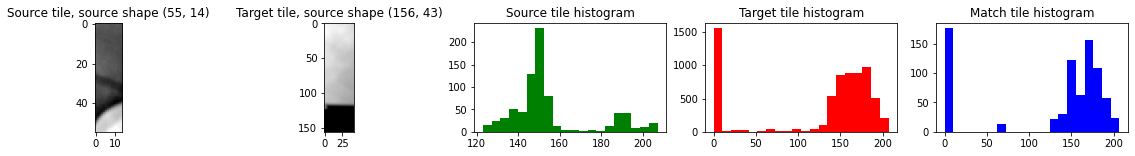

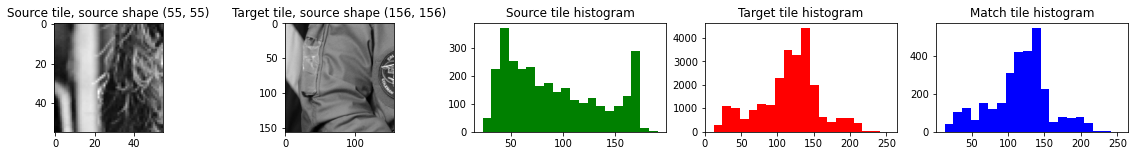

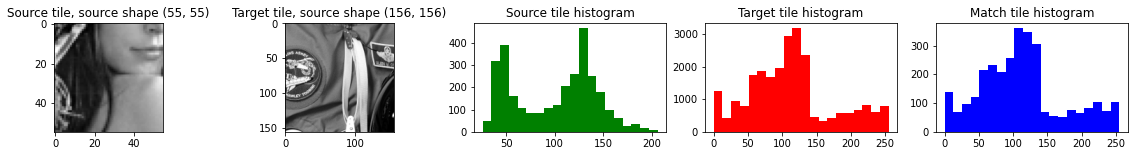

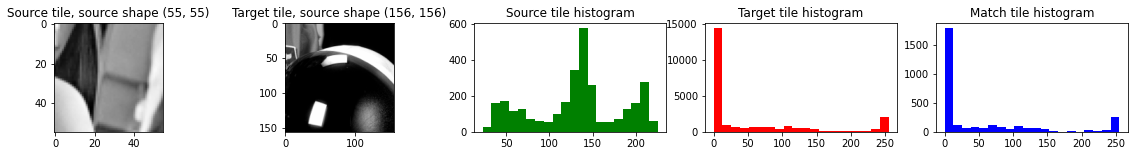

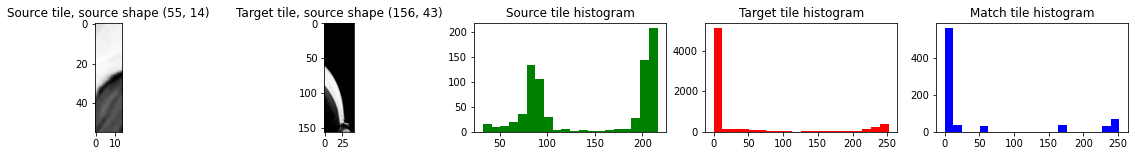

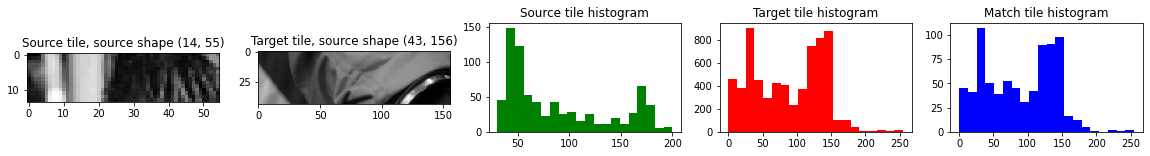

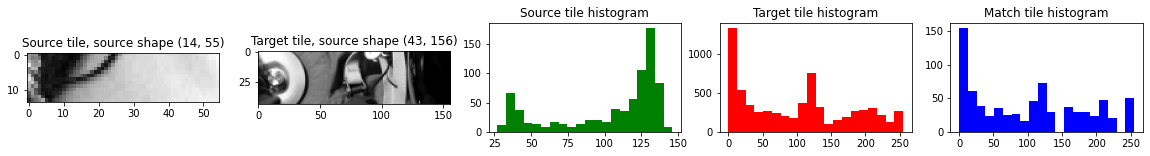

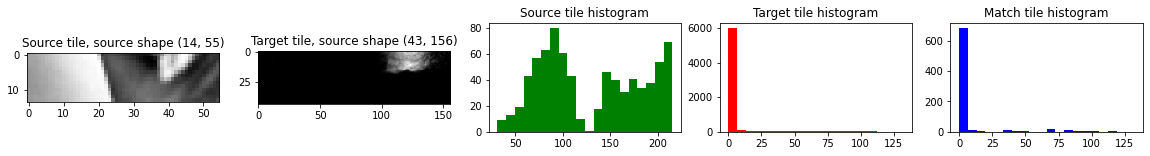

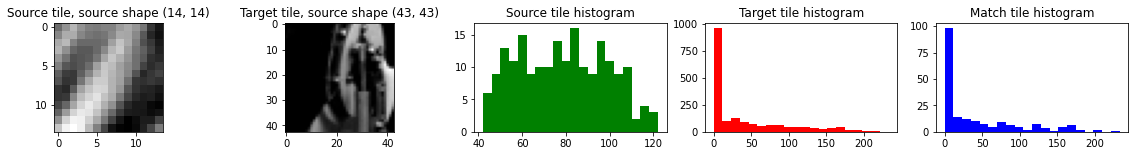

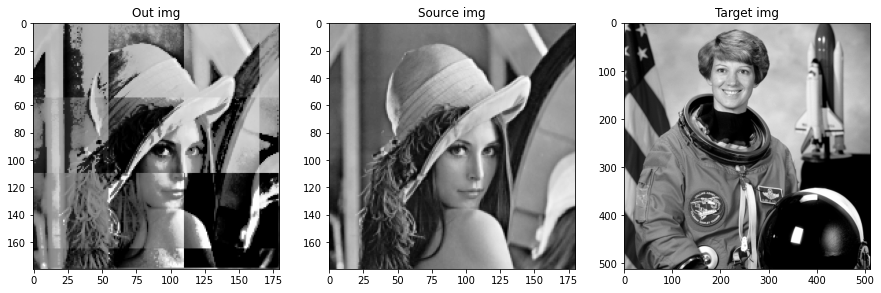

In [25]:
lena = io.imread(LennaPth,as_gray=True)
lenaCopy = io.imread(LennaPth,as_gray=True)

lena = transform.resize(lena,(180,180))
lenaCopy = transform.resize(lenaCopy,(180,180))

lena = lena*255
lena = lena.astype(np.uint8)

img =(rgb2gray(data.astronaut())*255).astype(np.uint8)

result = dap_hist_matching(lena,img,55)
plt.figure(figsize=(15,10))
subplot(131)
plt.title("Out img")
plt.imshow(result,cmap="gray")
subplot(132)
plt.title("Source img")
plt.imshow(lenaCopy,cmap="gray")
subplot(133)
plt.title("Target img")
plt.imshow(img,cmap="gray")

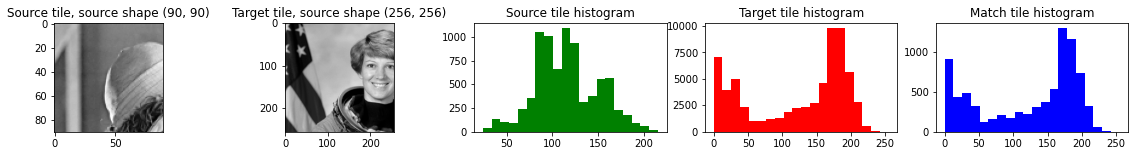

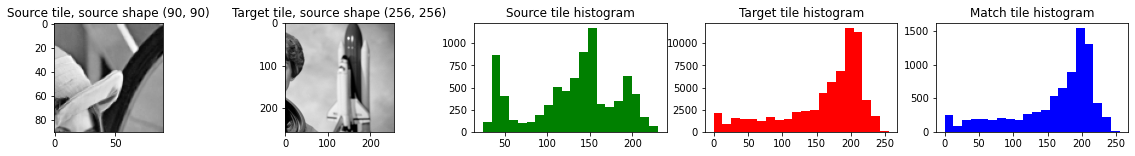

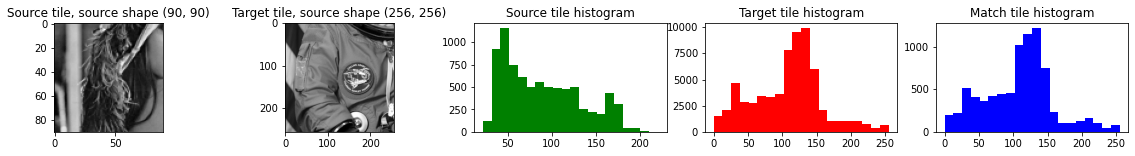

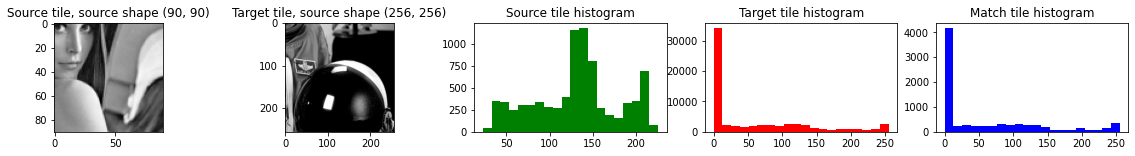

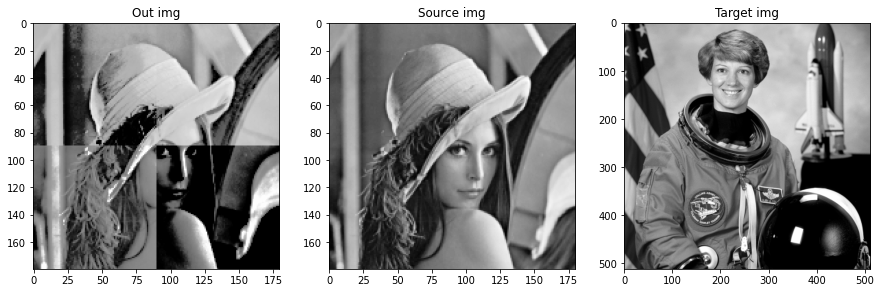

In [26]:
lena = io.imread(LennaPth,as_gray=True)
lenaCopy = io.imread(LennaPth,as_gray=True)
lenaCopy = transform.resize(lenaCopy,(180,180))
lena = transform.resize(lena,(180,180))
lena = lena*255
lena = lena.astype(np.uint8)

img =(rgb2gray(data.astronaut())*255).astype(np.uint8)

result = dap_hist_matching(lena,img,90)
plt.figure(figsize=(15,10))
subplot(131)
plt.title("Out img")
plt.imshow(result,cmap="gray")
subplot(132)
plt.title("Source img")
plt.imshow(lenaCopy,cmap="gray")
subplot(133)
plt.title("Target img")
plt.imshow(img,cmap="gray")